In [43]:
import os
import sys
from os import listdir
from os.path import isfile, join
import pandas as pd
import functools 
from collections import defaultdict

In [2]:
input_folder = "/data8t/mtx/scSNV/dataset_v1/kim/data/snv/cell_level_snv"
suffix = "_filtered_pass.vcf"

In [3]:
onlyfiles = [f for f in listdir(input_folder) if isfile(join(input_folder, f)) if f.endswith(suffix)]

In [25]:
min_shared_snv = 10
snv_dict = defaultdict(list)
sample_list = [] # to store sample names which will be column name of the dataframe
for f in onlyfiles:
    path_to_file = os.path.join(input_folder,f)
    current_file = open(path_to_file, 'r')
    sample_name = f.split("_")[0] 
    sample_list.append(sample_name)
    Lines = current_file.readlines()
    for line in Lines:
        if not line.startswith("#"):
            chrom = line.split()[0]
            position = line.split()[1]
            # here I need to use "__" to avoid the "_" in chr column
            snv_index = chrom + "__" + position
            snv_dict[snv_index].append(sample_name)
    current_file.close()

snv_filtered = defaultdict(list)
for snv in snv_dict:
    if len(snv_dict[snv]) >= min_shared_snv:
        snv_filtered[snv] = snv_dict[snv]
snv_filtered_name_list = list(snv_filtered.keys())

snv_df = pd.DataFrame(0, index=snv_filtered_name_list, columns=sample_list)

for snv in snv_filtered:
    for sample in snv_filtered[snv]:
        snv_df.loc[snv, sample] = 1
snv_df.index.name = "SNVid"

In [194]:
path_to_saved_snv_df = join("/data8t/mtx/scSNV/dataset_v1/kim/data/snv", "snv_matrix_10.csv")
snv_df.to_csv(path_to_saved_snv_df)

In [26]:
snv_df

,SRR2431459,SRR2431426,SRR2431405,SRR2431396,SRR2431437,SRR2431427,SRR2431386,SRR2431354,SRR2431353,SRR2431391,...,SRR2431438,SRR2431457,SRR2431368,SRR2431344,SRR2431406,SRR2431450,SRR2431364,SRR2431449,SRR2431397,SRR2431440
SNVid,,,,,,,,,,,,,,,,,,,,,
chr1__564598,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
chr1__565107,1,0,1,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
chr1__565282,1,0,0,1,1,1,0,0,1,1,...,0,0,0,1,0,1,0,1,0,1
chr1__565406,1,0,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,0,1,0,1
chr1__565508,1,0,0,0,0,0,0,0,0,1,...,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr12__32101449,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr12__32101471,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr12__32101489,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
gtf_index_df = pd.read_csv("/data8t/mtx/scSNV/dataset_v1/kim/data/gtf_index/GTF_index.csv", index_col='Geneid')

In [7]:
def search_snv_from_gtfindex(snv_list, gtf_index_df):
    # snv_list can be list or numpy array
    # for str, try to convert it to list(with only one snv)
    # each item in snv_list is named like chr7_123
    if isinstance(snv_list, str):
        snv_list = [snv_list]
    snv_location = defaultdict(list)
    j = 0
    for i in snv_list:
        j += 1
        if j%5000 == 0:
            print(j)
        chrom = i.split("__")[0]
        pos = int(i.split("__")[1])
        result_df = gtf_index_df[(gtf_index_df['chr'] == chrom) & (gtf_index_df['start'] <= pos) & (gtf_index_df['end'] >= pos)]
        gene_id_list = list(result_df.index.values)
        snv_location[i] = gene_id_list
    return snv_location

In [8]:
gtf_index_df

,chr,start,end,gene_name
Geneid,,,,
ENSG00000223972.4,chr1,11869,14412,DDX11L1
ENSG00000227232.4,chr1,14363,29806,WASH7P
ENSG00000243485.2,chr1,29554,31109,MIR1302-11
ENSG00000237613.2,chr1,34554,36081,FAM138A
ENSG00000268020.2,chr1,52473,54936,OR4G4P
...,...,...,...,...
ENSG00000198695.2,chrM,14149,14673,MT-ND6
ENSG00000210194.1,chrM,14674,14742,MT-TE
ENSG00000198727.2,chrM,14747,15887,MT-CYB


In [6]:
result = search_snv_from_gtfindex('chr1__26497340', gtf_index_df)

In [7]:
result

defaultdict(list,
            {'chr1__26497340': ['ENSG00000142684.7', 'ENSG00000236782.1']})

In [27]:
result_whole = search_snv_from_gtfindex(list(snv_df.index), gtf_index_df)

5000
10000
15000
20000
25000
30000
35000
40000
45000


In [46]:
result_whole

defaultdict(list,
            {'chr1__564598': ['ENSG00000230021.3', 'ENSG00000225972.1'],
             'chr1__565107': ['ENSG00000230021.3', 'ENSG00000225630.1'],
             'chr1__565282': ['ENSG00000230021.3', 'ENSG00000225630.1'],
             'chr1__565406': ['ENSG00000230021.3', 'ENSG00000225630.1'],
             'chr1__565508': ['ENSG00000230021.3', 'ENSG00000225630.1'],
             'chr1__565541': ['ENSG00000230021.3', 'ENSG00000225630.1'],
             'chr1__565591': ['ENSG00000230021.3', 'ENSG00000225630.1'],
             'chr1__565870': ['ENSG00000230021.3', 'ENSG00000225630.1'],
             'chr1__565976': ['ENSG00000230021.3', 'ENSG00000225630.1'],
             'chr1__566573': ['ENSG00000230021.3', 'ENSG00000237973.1'],
             'chr1__566816': ['ENSG00000230021.3', 'ENSG00000237973.1'],
             'chr1__566849': ['ENSG00000230021.3', 'ENSG00000237973.1'],
             'chr1__567119': ['ENSG00000230021.3', 'ENSG00000237973.1'],
             'chr1__567191': ['EN

In [32]:
snv_list = []
for snv in result_whole:
    gene_list = result_whole[snv]
    if len(gene_list) > 0:
        snv_list.append(snv)


In [33]:
len(snv_list)

41037

In [37]:
snv_list = list(set(snv_list))

In [38]:
len(snv_list)

41037

In [44]:
# gene
# the folder of gene expression which contains gene expression matrix and parsed data
gene_expression_folder = "/data8t/mtx/scSNV/dataset_v1/kim/data/quantification_stats/gene_expression_matrix"
GENE_MATRIX = "gene_expression_matrix.csv"
FEATURE_PARSE = "feature_parse_matrix.csv"
gene_matrix_file = os.path.join(gene_expression_folder, GENE_MATRIX)
feature_parse_file = os.path.join(gene_expression_folder, FEATURE_PARSE)
# extract gene efficient length from parsed file
feature_parse_df = pd.read_csv(feature_parse_file)
gene_length_df = feature_parse_df[['Geneid', 'Length']]
gene_length_df.set_index('Geneid', inplace=True)
# transform read counts to tpm
gene_matrix_df = pd.read_csv(gene_matrix_file, index_col='Geneid')
#cnt_transformed_save_to_local(gene_matrix_df, gene_length_df, gene_expression_folder)

In [56]:
dele_gene = gene_matrix_df.loc['ENSG00000188976.6',]

In [57]:
dele_snv = snv_df.loc['chr1__879687',]

In [60]:
dele_snv.value_counts()

1    89
0    32
Name: chr1__879687, dtype: int64

In [64]:
dele = pd.concat([dele_gene, dele_snv], axis=1)

In [69]:
dele.columns = ['gene','snv']

In [71]:
dele.to_csv("./one_gene_one_snv.csv")

In [63]:
import seaborn as sns

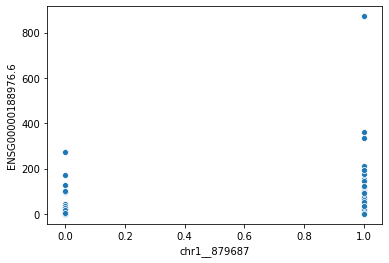

In [67]:
sns.scatterplot(x="chr1__879687", y="ENSG00000188976.6", data=dele)

In [12]:
result_whole

defaultdict(list,
            {'chr1__565282': ['ENSG00000230021.3', 'ENSG00000225630.1'],
             'chr1__565406': ['ENSG00000230021.3', 'ENSG00000225630.1'],
             'chr1__565508': ['ENSG00000230021.3', 'ENSG00000225630.1'],
             'chr1__565541': ['ENSG00000230021.3', 'ENSG00000225630.1'],
             'chr1__565591': ['ENSG00000230021.3', 'ENSG00000225630.1'],
             'chr1__565870': ['ENSG00000230021.3', 'ENSG00000225630.1'],
             'chr1__565976': ['ENSG00000230021.3', 'ENSG00000225630.1'],
             'chr1__566573': ['ENSG00000230021.3', 'ENSG00000237973.1'],
             'chr1__566816': ['ENSG00000230021.3', 'ENSG00000237973.1'],
             'chr1__566849': ['ENSG00000230021.3', 'ENSG00000237973.1'],
             'chr1__567119': ['ENSG00000230021.3', 'ENSG00000237973.1'],
             'chr1__567191': ['ENSG00000230021.3', 'ENSG00000237973.1'],
             'chr1__567242': ['ENSG00000230021.3', 'ENSG00000237973.1'],
             'chr1__567783': ['EN

In [11]:
gtf_index_df.loc['ENSG00000162616.8',]

chr              chr1
start        78444859
end          78483648
gene_name      DNAJB4
Name: ENSG00000162616.8, dtype: object

In [12]:
gtf_index_df.loc['ENSG00000142684.7',]

chr              chr1
start        26496362
end          26498551
gene_name      ZNF593
Name: ENSG00000142684.7, dtype: object

In [218]:
result_length = defaultdict(int)
for i in result:
    length = len(result[i])
    result_length[length] += 1

In [219]:
result_length

defaultdict(int, {2: 1845, 1: 7538, 0: 727, 3: 184, 4: 17, 9: 1})

In [221]:
# just select the snv located in gene:
gene_list_tmp = []
for i in result:
    if len(result[i]) > 0:
        gene_list_tmp.append(i)


In [222]:
len(gene_list_tmp)

9585

In [224]:
snv_df.loc[gene_list_tmp].to_csv("/data8t/mtx/scSNV/dataset_v1/kim/data/snv/valid_snv.csv")